# LDA Topic Modeling

This notebook implements topic modeling using gensim LDA

## Imports

In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
pd.set_option('display.width',-1)

In [30]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

## Load Data

In [24]:
df = pd.read_csv('../data/all_data.csv')
df.head()

,reviews,rating,company
0,Great card! We get cash back for our grocery a...,4.0,American Express Blue Cash Preferred
1,While traveling we had to keep calling the Cre...,1.0,Credit One Bank
2,Great card to have! Love all the additional cr...,5.0,Capital One Quicksilver Rewards
3,no tengo tanta experiencia asi que no puedo da...,2.0,Citi Double Cash Card
4,This is a basic credit card. The cash back dea...,4.0,Bank of America Cash Rewards Credit Card


In [3]:
df.shape

(25708, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25708 entries, 0 to 25707
Data columns (total 3 columns):
reviews    25708 non-null object
rating     25708 non-null float64
company    25708 non-null object
dtypes: float64(1), object(2)
memory usage: 602.7+ KB


In [5]:
# Drop rows with missing value if any
df = df.dropna().reset_index(drop = True)

In [31]:
# Remove wide space in review texts
df['reviews']  = df['reviews'].apply(detokenizer)
df.to_csv('../data/all_data.csv', index = False) # save as csv file

In [32]:
#Display the index row
print_review(df, index =8489)

Review: i signed up for my card to have an emergency fund source for big dollar purchases that seem to always happen just before the next paycheck  it has been excellent so far  i've enjoyed having it, the interest rate is fantastic, and the payment terms have been more than fair  i love the rotating categories as well  so far they've been a lot of places that i shop, so i've gotten to get reward points for a lot of my purchases  this is definitely a card i'd recommend
Rating: 5.0
Credit card: Discover it Cash Back


In [3]:
# reload the data
df =pd.read_csv('../data/all_data.csv') 

In [4]:
review_count = df.groupby('company')['reviews'].count().sort_values(ascending = False)
review_count.head()

company
Bank of America Cash Rewards Credit Card    2476
Capital One Quicksilver Rewards             2292
Capital One Venture Rewards                 2204
Capital One Platinum                        2103
Credit One Bank                             2016
Name: reviews, dtype: int64

In [5]:
len(review_count)

40

Text(0, 0.5, 'number of reviews')

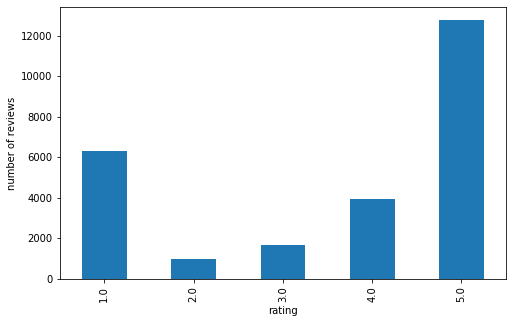

In [6]:
df.groupby('rating')['reviews'].count().plot(kind = 'bar', figsize = (8,5))
plt.ylabel('number of reviews')
#plt.savefig('../figures/fig1.pdf')

# Data Pre-processing
- Document cleaning
- Tokenization
- Lemmatization
- Stopwords removal
- Bag of words
- Topic modeling with LDA

In [33]:
from nltk.corpus import stopwords
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel, LdaModel, LdaMulticore

In [34]:
# text preprocessing
df = pre_process_text(df, 'reviews') 

In [35]:
# Add additional stop words to the default nltk stopwords
my_stop_words = ['capital','america', 'redcard', 'target','amazon', 'card', 'citibank', 'credit','merrick', 'discover', 'citi',
                 'amex', 'express', 'go', 'paypal', 'chase', 'american', 'one', 'would', 'ask','asking','really', 
                 'get', 'know', 'express', 'ever','use','say', 'recently', 'also', 'always', 'call', 'give',  'tell', 
                 'take', 'never', 'costco', 'time', 'make', 'account', 'try','number', 'send', 'new', 'even',
                 'sony', 'us', 'husband', 'car', 'capitol', 'wife', 'book','could','okay', 'mastercard', 'want',
                 'honestly', 'eppicard', 'need', 'family', 'cap', 'another', 'line', 'com', 'fico', 'quicksilver',
                'link', 'sear', 'scotiabank', 'barclays', 'first']

stop_words = stopwords.words('english')
stop_words.extend(my_stop_words)

In [36]:
# tokenization
df['tokens'] =  df['reviews'].apply(my_tokenizer)

In [52]:
def word_count(text):
    """Plot the most frequency words in the corpus"""
    all_reviews = ' '.join(text) # join all reviews
    token_count = Counter(my_tokenizer(all_reviews)) # count each word
    common_words =  dict( token_count.most_common(n=25) ) # count most common 20 words
    freq_plot = pd.Series(common_words, index=None).plot(kind = 'bar', figsize=(10,5))
    plt.ylabel('count')
    #plt.savefig('../figures/fig2.pdf')

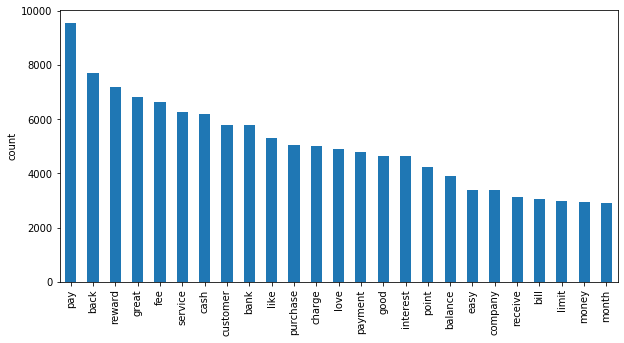

In [18]:
word_count(df.reviews)

## Bigrams and Trigrams

In [13]:
def add_bigram(token_list):
    """add bigrams in the data"""
    bigram = gensim.models.Phrases(token_list)
    bigram = [bigram[line] for line in token_list]
    return bigram

def add_trigram(token_list):
    """add trigrams in the data"""
    bigram = add_bigram(token_list)
    trigram = gensim.models.Phrases(bigram)
    trigram = [trigram[line] for line in bigram]
    return trigram

In [14]:
df['bigram_tokens'] = add_bigram(df.tokens)
df['trigram_tokens'] = add_trigram(df.tokens)
df.head()

,reviews,rating,company,tokens,bigram_tokens,trigram_tokens
0,great card! we get cash back for our grocery a...,4.0,American Express Blue Cash Preferred,"[great, cash, back, grocery, gas, purchase, fo...","[great, cash_back, grocery_gas, purchase, food...","[great, cash_back, grocery_gas, purchase, food..."
1,while traveling we had to keep calling the cre...,1.0,Credit One Bank,"[travel, keep, customer, service, lock, transa...","[travel, keep, customer_service, lock, transac...","[travel, keep, customer_service, lock, transac..."
2,great card to have! love all the additional cr...,5.0,Capital One Quicksilver Rewards,"[great, love, additional, rat, check, feature]","[great, love, additional, rat, check, feature]","[great, love, additional, rat, check, feature]"
3,no tengo tanta experiencia asi que no puedo da...,2.0,Citi Double Cash Card,"[tengo, tanta, experiencia, asi, que, puedo, d...","[tengo, tanta, experiencia, asi, que, puedo, d...","[tengo, tanta, experiencia, asi, que, puedo, d..."
4,this is a basic credit card the cash back dea...,4.0,Bank of America Cash Rewards Credit Card,"[basic, cash, back, deal, nice, cash, year, an...","[basic, cash_back, deal, nice, cash, year, ann...","[basic, cash_back, deal, nice, cash, year, ann..."


In [15]:
# Create a dictornary, i.e associate each unique token with unique integer ID
dictionary = corpora.Dictionary(df.trigram_tokens)
print(dictionary)

# Bag of words (document-term matrix)
corpus = [dictionary.doc2bow(text) for text in df.trigram_tokens]
print('Number of documents: %s'%len(corpus))

Dictionary(14760 unique tokens: ['apr', 'cash_back', 'food_gas', 'fully', 'great']...)
Number of documents: 25708


In [24]:
# Tfidf
# tfidf = models.TfidfModel(corpus)
# corpus_tfidf = tfidf[corpus]

In [25]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Topic modeling with LDA

In [66]:
def compute_coherence_lda(corpus, dictionary, start=None, limit=None, step=None):
    """Compute c_v coherence for various number of topics """
    topic_coherence = []
    model_list = []
    tokens_list = df.tokens.values.tolist()
    texts = [[token for sub_token in tokens_list for token in sub_token]]
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,id2word=dictionary, random_state=0,num_topics=num_topics,
                         alpha = 'auto', eta = 'auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        topic_coherence.append(coherencemodel.get_coherence())

    return model_list, topic_coherence

In [ ]:
model_list, topic_coherence = compute_coherence_lda(corpus, dictionary, start=2, limit=40, step=6)

In [ ]:
# Plot
num_topics = range(2, 40, 6)
plt.plot(num_topics, topic_coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for top, cv in zip(num_topics, topic_coherence):
    print("{} topics  have coherence score of {}".format(top, round(cv, 4)))

In [39]:
#optimal_lda = model_list[4]

In [17]:
tokens_list = df.tokens.values.tolist()
texts = [[token for sub_token in tokens_list for token in sub_token]]

In [28]:
# lda model
model = LdaModel(corpus=corpus,id2word=dictionary,
                     random_state=0,num_topics=20,
                     passes=20,iterations =1000,
                     alpha = 'auto', eta = 'auto',
                     update_every=1,chunksize=2000)

In [29]:
model.show_topics(num_topics=10, num_words=10)

[(4,
  '0.041*"premier" + 0.039*"treat" + 0.037*"good_fit" + 0.030*"help_rebuild" + 0.028*"freeze" + 0.023*"large_purchase" + 0.023*"waive" + 0.023*"useless" + 0.023*"convenience" + 0.021*"maintain"'),
 (2,
  '0.046*"vacation" + 0.039*"expense" + 0.034*"everywhere" + 0.032*"emergency" + 0.031*"ability" + 0.029*"products" + 0.025*"app_easy" + 0.022*"super_easy" + 0.021*"hotel" + 0.018*"beat"'),
 (6,
  '0.033*"miss_payment" + 0.031*"three" + 0.025*"protection" + 0.024*"upgrade" + 0.020*"annoy" + 0.020*"come_handy" + 0.019*"else" + 0.019*"customer_support" + 0.018*"raise_limit" + 0.018*"risk"'),
 (10,
  '0.120*"excellent" + 0.088*"miles" + 0.039*"anywhere" + 0.028*"world" + 0.027*"useful" + 0.025*"opportunity" + 0.023*"student" + 0.021*"reliable" + 0.017*"fly" + 0.016*"bonus_point"'),
 (15,
  '0.039*"job" + 0.025*"consumer" + 0.020*"center" + 0.019*"replace" + 0.019*"felt" + 0.018*"overseas" + 0.018*"connect" + 0.017*"normal" + 0.016*"next_month" + 0.016*"keep_track"'),
 (18,
  '0.140*"ea

In [30]:
from wordcloud import WordCloud

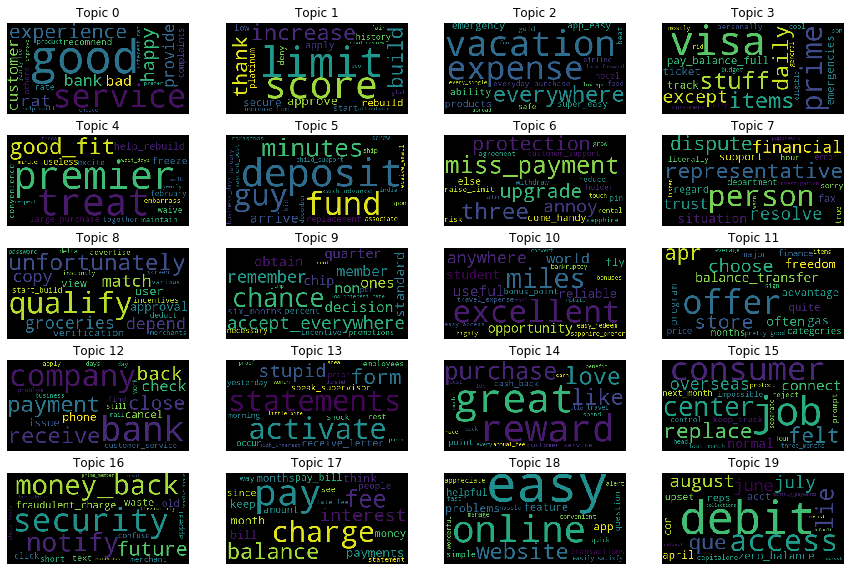

In [31]:
fig, axes = plt.subplots(5,4, figsize=(15,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topics = model.show_topics(num_topics=20, num_words=20, formatted=False)
    plt.imshow(WordCloud().fit_words(dict(topics[i][1])))
    plt.axis("off")
    plt.title("Topic {}".format(i))
# plt.savefig('../figures/fig3.pdf')

In [33]:
import pyLDAvis.gensim

In [46]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary,sort_topics=False)